In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from skbio.diversity import alpha_diversity
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from skbio.stats.distance import permanova
from skbio.stats.distance import mantel
import matplotlib.pyplot as plt
from skbio.stats.composition import ancom
from skbio.stats.ordination import rda

In [6]:
barcodes = pd.read_excel('../Data/qPCR/NxW MinION master list - 2.xlsx', sheet_name = 'Index PCR', engine='openpyxl')
barcodes = barcodes[~barcodes['Barcode'].isnull()]
barcodes = barcodes[['Sample name', 'Barcode','Notes']].set_index('Sample name')
barcodes.head()

,Barcode,Notes
Sample name,,
2,1.0,NxW_A library
6,2.0,NxW_A library
15,3.0,NxW_A library
16,4.0,NxW_A library
19,5.0,NxW_A library


In [7]:
barcodes.tail()

,Barcode,Notes
Sample name,,
CalEXn_B,95.0,NxW_B library
Zymo_B,96.0,NxW_B library
NaN,92.0,NxW_B library
NaN,93.0,NxW_B library
NaN,94.0,NxW_B library


In [8]:
plot_key = pd.read_excel('../Data/ID and Plots.xlsx', engine='openpyxl')
plot_key.head()

,ID,Plot,Nitrogen,Water,Block,Water rate (%ET),Nrate (llbs/acre)
0,114,1N,4,1,1,100,155
1,114,1S,4,1,1,100,155
2,111,2N,1,1,1,100,20
3,111,2S,1,1,1,100,20
4,115,3N,5,1,1,100,200


In [11]:
soil_key = pd.read_excel('../Data/Sequencing/Soil key/Soil DNA extraction key.xlsx', engine='openpyxl')
soil_key = soil_key[soil_key['Skipping'] != 'Yes']
soil_key = soil_key[soil_key['Quality'] != 'Failed']
soil_key = soil_key[['Sample name','Sample date','Plot']]
soil_key.rename({'Plot':'Sample ID'}, axis = 1, inplace = True)
soil_key = soil_key[~soil_key['Sample ID'].isnull()]
soil_key[['Plot', 'ID', 'Nitrogen', 'Water', 'Block', 'Direction']] = np.nan
soil_key_nxwater = soil_key.copy()
for index, row in soil_key.iterrows():
    if (row['Sample ID'] == 'King Fischer') | (row['Sample ID'] == 'stove pipe prairie') | (row['Sample ID'] == 'NaN'):
        continue
    tmp_data = plot_key[plot_key['Plot'] == row['Sample ID']]
    soil_key_nxwater.loc[index, 'Plot'] = tmp_data['Plot'].iloc[0]
    soil_key_nxwater.loc[index, 'ID'] = tmp_data['ID'].iloc[0]
    soil_key_nxwater.loc[index, 'Block'] = tmp_data['Block'].iloc[0]
    soil_key_nxwater.loc[index, 'Water'] = tmp_data['Water'].iloc[0]
    soil_key_nxwater.loc[index, 'Nitrogen'] = tmp_data['Nitrogen'].iloc[0]
soil_key_nxwater['Direction'] = [x[-1:] for x in soil_key['Sample ID']]
soil_key_nxwater['Sample date'] = [x.strftime('%m-%d') for x in soil_key['Sample date']]
soil_key_nxwater = soil_key_nxwater[soil_key_nxwater['Nitrogen'].isin([1,5,6])]
soil_key_nxwater.set_index('Sample name', inplace = True)
soil_key_nxwater.head()

,Sample date,Sample ID,Plot,ID,Nitrogen,Water,Block,Direction
Sample name,,,,,,,,
2,07-27,15N,15N,225.0,5.0,2.0,2.0,N
6,07-27,32N,32N,311.0,1.0,1.0,3.0,N
15,07-27,8N,8N,121.0,1.0,2.0,1.0,N
16,07-27,2S,2S,111.0,1.0,1.0,1.0,S
19,07-27,30N,30N,321.0,1.0,2.0,3.0,N


In [14]:
# poudre_key = soil_key[(soil_key['Sample ID'] == 'King Fischer') | (soil_key['Sample ID'] == 'stove pipe prairie')]
# poudre_key

In [84]:
data_a = pd.read_csv('../Data/Sequencing/EMU.rel_abund.final.csv', index_col=0)
data_a.columns = [x + 'a' if 'barcode' in x else x for x in data_a.columns]
# data_a_taxa = data_a.loc[:,'superkingdom':'species']
# data_a = data_a.loc[:,'tax_id':]#.set_index('tax_id')
# print(data_a.shape)
# data_a = data_a[data_a.sum(axis = 1) > 0]
print(data_a.shape)
data_a.head()

(856, 102)


,superkingdom,phylum,class,order,family,genus,species,tax_id,barcode01a,barcode02a,...,barcode86a,barcode87a,barcode88a,barcode89a,barcode90a,barcode91a,barcode92a,barcode93a,barcode95a,barcode96a
0,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Verrucomicrobia subdivision 3,Limisphaera,Limisphaera ngatamarikiensis,1324935,0.010091,0.008898,...,0.008928,0.004646,0.008249,0.008432,0.006726,0.009163,NaN,NaN,NaN,NaN
1,Bacteria,Verrucomicrobia,Spartobacteria,Chthoniobacterales,Chthoniobacteraceae,Chthoniobacter,Chthoniobacter flavus,191863,0.021852,0.015567,...,0.017780,0.008632,0.022542,0.013441,0.023716,0.018358,NaN,NaN,0.057296,NaN
2,Bacteria,Verrucomicrobia,Terrimicrobia,Terrimicrobiales,Terrimicrobiaceae,Terrimicrobium,Terrimicrobium sacchariphilum,690879,0.004993,0.004780,...,0.007931,0.003849,0.004320,0.005192,0.005483,0.007299,NaN,NaN,0.015210,NaN
3,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Verrucomicrobiaceae,Verrucomicrobium,Verrucomicrobium spinosum,2736,0.006471,0.001330,...,NaN,NaN,0.001509,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Verrucomicrobiaceae,Roseimicrobium,Roseimicrobium gellanilyticum,748857,0.005127,0.001894,...,NaN,NaN,0.001462,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
data_b = pd.read_csv('../Data/Sequencing/NxW_B_EMU.rel_abund.final.csv', index_col=0)
data_b.columns = [x + 'b' if 'barcode' in x else x for x in data_b.columns]
# data_b_taxa = data_b.loc[:,'superkingdom':'species']
# data_b = data_b.loc[:,'tax_id':]#.set_index('tax_id')
# print(data_b.shape)
# data_b = data_b[data_b.sum(axis = 1) > 0]
print(data_b.shape)
data_b.head()

(1464, 93)


,superkingdom,phylum,class,order,family,genus,species,tax_id,barcode01b,barcode02b,...,barcode77b,barcode78b,barcode79b,barcode80b,barcode81b,barcode82b,barcode92b,barcode93b,barcode95b,barcode96b
0,Bacteria,Candidatus Saccharibacteria,NaN,NaN,NaN,NaN,Candidatus Saccharibacteria bacterium YM_S32_T...,2056494,0.003407,0.001785,...,0.007033,0.002712,0.003656,0.003390,0.006441,0.002453,NaN,0.003829,NaN,NaN
1,Bacteria,NaN,Candidatus Babeliae,Candidatus Babeliales,Candidatus Babeliaceae,Candidatus Babela,Candidatus Babela massiliensis,673862,0.001080,NaN,...,0.003381,0.001572,0.001263,0.001063,0.001020,0.003774,NaN,NaN,NaN,NaN
2,Bacteria,Bacteroidetes,Chitinophagia,Chitinophagales,Chitinophagaceae,Ferruginibacter,Ferruginibacter paludis,1310417,0.003720,NaN,...,NaN,0.001448,0.005699,0.001943,0.002565,NaN,NaN,0.001095,NaN,NaN
3,Bacteria,Bacteroidetes,Chitinophagia,Chitinophagales,Chitinophagaceae,Flavisolibacter,Flavisolibacter ginsengisoli,462367,0.001489,NaN,...,NaN,NaN,0.002272,0.001165,0.001755,NaN,NaN,0.000901,NaN,NaN
4,Bacteria,Bacteroidetes,Chitinophagia,Chitinophagales,Chitinophagaceae,Flavisolibacter,Flavisolibacter ginsengiterrae,398045,0.001908,NaN,...,0.001410,NaN,0.001934,0.001171,0.000959,NaN,NaN,0.000897,NaN,NaN


In [87]:
data = pd.merge(data_a, data_b, on = ['superkingdom', 'phylum', 'class', 'order', 'family',
       'genus', 'species','tax_id'], how = 'outer')
print(len(set(data_a['tax_id'].append(data_b['tax_id']))))
print(data.shape)
data.head()

1556
(1556, 187)


,superkingdom,phylum,class,order,family,genus,species,tax_id,barcode01a,barcode02a,...,barcode77b,barcode78b,barcode79b,barcode80b,barcode81b,barcode82b,barcode92b,barcode93b,barcode95b,barcode96b
0,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Verrucomicrobia subdivision 3,Limisphaera,Limisphaera ngatamarikiensis,1324935,0.010091,0.008898,...,0.004257,0.003301,0.003230,0.003936,0.004828,0.004064,NaN,0.001702,NaN,NaN
1,Bacteria,Verrucomicrobia,Spartobacteria,Chthoniobacterales,Chthoniobacteraceae,Chthoniobacter,Chthoniobacter flavus,191863,0.021852,0.015567,...,0.018550,0.020115,0.010500,0.010008,0.012191,0.009868,NaN,0.041281,NaN,NaN
2,Bacteria,Verrucomicrobia,Terrimicrobia,Terrimicrobiales,Terrimicrobiaceae,Terrimicrobium,Terrimicrobium sacchariphilum,690879,0.004993,0.004780,...,0.003951,0.003363,0.001865,0.002690,0.003211,0.002578,NaN,0.006619,NaN,NaN
3,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Verrucomicrobiaceae,Verrucomicrobium,Verrucomicrobium spinosum,2736,0.006471,0.001330,...,0.002059,0.000970,0.001800,0.001417,0.001777,NaN,NaN,0.001276,NaN,NaN
4,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Verrucomicrobiaceae,Roseimicrobium,Roseimicrobium gellanilyticum,748857,0.005127,0.001894,...,0.001424,0.001697,0.001173,0.001119,0.001289,0.001798,NaN,NaN,NaN,NaN


In [88]:
data.loc[:, 'barcode01b':].sum().sum()

84.99999999999889

In [26]:
# data_filtered = data.copy()
# for index, row in data_filtered.iterrows():
#     for column in data_filtered.select_dtypes(include=np.number).columns.tolist():
#         if data_filtered.loc[index, column] < 0.0007:
#             data_filtered.loc[index, column] = np.nan

In [27]:
# data_filtered.loc[:, 'barcode01':].sum().sum()

93.99819512053367

In [89]:
mapping_file = pd.merge(soil_key_nxwater, barcodes, left_index=True, right_index=True)
mapping_file['Barcode_key'] = ['barcode' + str(int(x)).zfill(2) for x in mapping_file['Barcode']]
barcodes_list = []
for i, barcode in enumerate(mapping_file['Barcode_key']):
    if '_A' in mapping_file.iloc[i,9]:
        barcodes_list.append(barcode + 'a')
    if '_B' in mapping_file.iloc[i,9]:
        barcodes_list.append(barcode + 'b')
mapping_file['Barcode_key'] = barcodes_list
print(mapping_file.shape)
mapping_file.head()

(169, 11)


,Sample date,Sample ID,Plot,ID,Nitrogen,Water,Block,Direction,Barcode,Notes,Barcode_key
Sample name,,,,,,,,,,,
2,07-27,15N,15N,225.0,5.0,2.0,2.0,N,1.0,NxW_A library,barcode01a
6,07-27,32N,32N,311.0,1.0,1.0,3.0,N,2.0,NxW_A library,barcode02a
15,07-27,8N,8N,121.0,1.0,2.0,1.0,N,3.0,NxW_A library,barcode03a
16,07-27,2S,2S,111.0,1.0,1.0,1.0,S,4.0,NxW_A library,barcode04a
19,07-27,30N,30N,321.0,1.0,2.0,3.0,N,5.0,NxW_A library,barcode05a


In [90]:
barcode_controls = ['barcode85a',
 'barcode95a',
 'barcode88a',
 'barcode91a',
 'barcode92a',
 'barcode87a',
 'barcode96a',
 'barcode90a',
 'barcode93a',
 'barcode86a',
 'barcode89a',
 'barcode95b',
 'barcode96b',
 'barcode92b',
 'barcode93b',
 'barcode94b'
]

In [78]:
# poudre_key_mapping_file = pd.merge(poudre_key, barcodes, left_index=True, right_index=True)
# poudre_key_mapping_file['Barcode_key'] = ['barcode' + str(int(x)).zfill(2) for x in poudre_key_mapping_file['Barcode']]
# print(poudre_key_mapping_file.shape)
# poudre_key_mapping_file.head()

In [91]:
zymo_true = pd.DataFrame(index = ['Zymo'], data = {'Bacillus': [17.4], 'Enterococcus': [9.9], 'Escherichia':[10.1],
                                                    'Lactobacillus':[18.4], 'Listeria': [14.1], 'Pseudomonas': [4.2],
                                                   'Salmonella': [10.4], 'Staphylococcus': [15.5]})

In [92]:
zymo_true_species = pd.DataFrame(index = ['Zymo'], data = {'Bacillus subtilis': [17.4], 'Enterococcus faecalis': [9.9], 
                                                           'Escherichia coli':[10.1],
                                                    'Limosilactobacillus fermentum':[18.4], 'Listeria monocytogenes': [14.1], 
                                                           'Pseudomonas aeruginosa': [4.2],
                                                   'Salmonella enterica': [10.4], 'Staphylococcus aureus': [15.5]})

In [93]:
zymo = data[['species','barcode96a','barcode96b']]

In [94]:
zymo

,species,barcode96a,barcode96b
0,Limisphaera ngatamarikiensis,NaN,NaN
1,Chthoniobacter flavus,NaN,NaN
2,Terrimicrobium sacchariphilum,NaN,NaN
3,Verrucomicrobium spinosum,NaN,NaN
4,Roseimicrobium gellanilyticum,NaN,NaN
...,...,...,...
1551,Listeria grayi,NaN,0.000420
1552,Staphylococcus petrasii,NaN,0.000486
1553,Staphylococcus schleiferi,NaN,NaN
1554,Staphylococcus stepanovicii,NaN,0.000307


In [96]:
zymo_grouped = zymo.groupby('species').sum()
zymo_grouped = zymo_grouped[zymo_grouped['barcode96a'] > 0].T*100
for i in zymo_grouped:
    if zymo_grouped[i].mean() < 2:
        zymo_grouped = zymo_grouped.rename(columns = {i:'Other'})
zymo_grouped = zymo_grouped.groupby(zymo_grouped.columns, axis=1).sum()
zymo_grouped

species,Bacillus subtilis,Enterococcus faecalis,Escherichia coli,Limosilactobacillus fermentum,Listeria monocytogenes,Other,Salmonella enterica,Staphylococcus aureus
barcode96a,25.514470,12.952302,5.301626,8.875627,20.025866,6.895849,7.379529,13.054730
barcode96b,27.305186,12.404662,5.477157,8.107169,19.802451,6.764389,7.666215,12.228586


In [103]:
zymo_grouped_full = pd.concat([zymo_grouped, zymo_true_species])
print(zymo_grouped_full.index)
zymo_grouped_full.index = ['Library_A','Library_B','Expected']
zymo_grouped_full

Index(['barcode96a', 'barcode96b', 'Zymo'], dtype='object')


,Bacillus subtilis,Enterococcus faecalis,Escherichia coli,Limosilactobacillus fermentum,Listeria monocytogenes,Other,Salmonella enterica,Staphylococcus aureus,Pseudomonas aeruginosa
Library_A,25.514470,12.952302,5.301626,8.875627,20.025866,6.895849,7.379529,13.054730,NaN
Library_B,27.305186,12.404662,5.477157,8.107169,19.802451,6.764389,7.666215,12.228586,NaN
Expected,17.400000,9.900000,10.100000,18.400000,14.100000,NaN,10.400000,15.500000,4.2


In [105]:
bc_dm = beta_diversity('braycurtis', zymo_grouped_full.fillna(0), zymo_grouped_full.index)

In [113]:
bc_df_genus_df = pd.DataFrame(bc_dm.data, index = bc_dm.ids, columns = bc_dm.ids)

In [116]:
bc_df_genus_df

,Library_A,Library_B,Expected
Library_A,0.000000,0.023779,0.239885
Library_B,0.023779,0.000000,0.250293
Expected,0.239885,0.250293,0.000000


Text(0.5, 0, '')

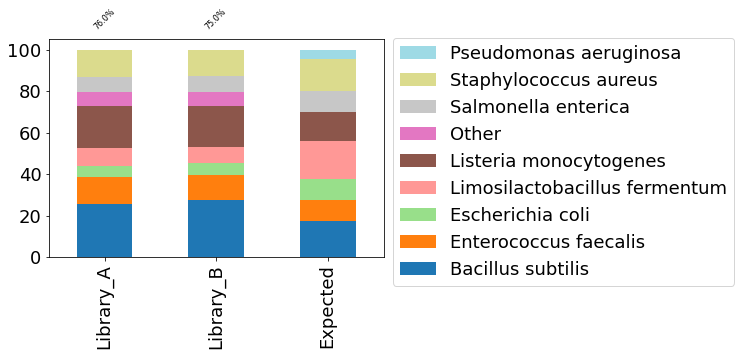

In [117]:
ax = zymo_grouped_full.plot(kind='bar', stacked=True, cmap='tab20', fontsize=18)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.0, 1.05), loc=2, fontsize = 18)
for i in range(len(zymo_grouped_full.index) - 1):
    ax.annotate(format(100 - bc_df_genus_df['Expected'].values[i] * 100, '.1f') + '%',
                   (i, 105), ha='center', va='bottom',
                   size=8, xytext=(0, 8),
                   textcoords='offset points', rotation=45)
ax.set_xlabel('', fontsize = 18)

In [119]:
otu_table = data.loc[:,'tax_id':].fillna(0)
otu_table.set_index('tax_id', inplace = True)
# print(otu_table.isna().sum().sum())
print(otu_table.shape)
otu_table = otu_table[otu_table.sum(axis=1) > 0].T
otu_table = otu_table[otu_table.sum(axis=1) > 0]
otu_table = otu_table[~otu_table.index.isin(barcode_controls)]
otu_table = otu_table[~otu_table.index.isin(['barcode33', 'barcode67'])]
print(otu_table.shape)
otu_table.tail()

(1556, 179)
(164, 1556)


tax_id,1324935,191863,690879,2736,748857,658062,1612172,496014,1892851,1855912,...,76726,2316527,1697973,2589080,1806506,1641,1276936,1295,643214,208962
barcode78b,0.003301,0.020115,0.003363,0.000970,0.001697,0.007092,0.089294,0.019624,0.003266,0.020813,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
barcode79b,0.003230,0.010500,0.001865,0.001800,0.001173,0.004370,0.077091,0.009178,0.003076,0.029179,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
barcode80b,0.003936,0.010008,0.002690,0.001417,0.001119,0.008381,0.108144,0.013195,0.001958,0.032449,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
barcode81b,0.004828,0.012191,0.003211,0.001777,0.001289,0.011669,0.072480,0.009582,0.004425,0.028327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
barcode82b,0.004064,0.009868,0.002578,0.000000,0.001798,0.006680,0.100943,0.011035,0.003069,0.030758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
otu_table = otu_table[otu_table.index.isin(mapping_file['Barcode_key'])]
full_bc = beta_diversity('braycurtis', otu_table, otu_table.index)
full_pc = pcoa(full_bc)

/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.04166453050404778 and the largest is 2.748812700660987.
  RuntimeWarning


In [136]:
full_pc.samples

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC151,PC152,PC153,PC154,PC155,PC156,PC157,PC158,PC159,PC160
barcode01a,-0.120907,-0.128233,0.163724,-0.037401,0.099605,-0.017126,-0.059303,0.042060,-0.119984,0.039609,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
barcode02a,0.099858,0.027631,-0.059891,-0.060763,0.031276,0.025672,-0.039217,0.029980,-0.003962,-0.044501,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
barcode03a,0.136035,-0.071525,0.053328,0.036807,-0.095670,0.211747,0.098265,0.001910,-0.066672,-0.140702,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
barcode04a,-0.140305,0.017689,-0.109505,0.020331,-0.041723,0.000883,-0.008279,-0.001257,0.033906,-0.009133,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
barcode05a,0.171555,0.009066,0.154323,-0.040857,-0.087747,0.014375,0.023585,-0.009180,0.041472,-0.007708,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
barcode78b,0.036353,0.128038,-0.106510,0.063500,-0.085481,0.005848,0.067990,0.031011,-0.064230,0.039229,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
barcode79b,-0.079335,0.159705,0.212481,0.001653,-0.071673,-0.060489,-0.054759,-0.035385,-0.072277,0.044385,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
barcode80b,-0.040328,0.153012,0.011430,0.034011,-0.022966,-0.058747,0.013767,-0.029103,-0.017436,0.017380,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
barcode81b,-0.026945,0.126248,0.159673,-0.013723,-0.049286,-0.039427,0.001541,-0.018440,-0.050343,0.019032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
plotting_df = mapping_file.copy()
plotting_df = plotting_df[plotting_df['Barcode_key'].isin(otu_table.index)]
plotting_df = plotting_df[~plotting_df['Barcode_key'].isin(barcode_controls)]
plotting_df['PCA1_bc'] = full_pc.samples['PC1'].values
plotting_df['PCA2_bc'] = full_pc.samples['PC2'].values
plotting_df['PCA3_bc'] = full_pc.samples['PC3'].values

In [138]:
treatment_perm = permanova(full_bc, plotting_df['Water'].values, permutations=999)
treatment_perm

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     160
number of groups                  2
test statistic              2.50446
p-value                       0.003
number of permutations          999
Name: PERMANOVA results, dtype: object

In [139]:
treatment_perm = permanova(full_bc, plotting_df['Nitrogen'].values, permutations=999)
treatment_perm

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     160
number of groups                  3
test statistic              2.76354
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

In [140]:
treatment_perm = permanova(full_bc, plotting_df['Sample date'].values, permutations=999)
treatment_perm

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     160
number of groups                  5
test statistic              4.16454
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

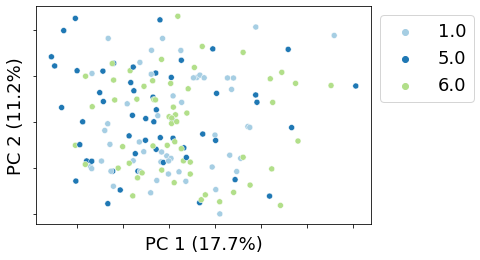

In [141]:
# with filtering
ax = sns.scatterplot(x = 'PCA1_bc', y = 'PCA2_bc', hue = 'Nitrogen', data = plotting_df, palette = 'Paired')
# for i, txt in enumerate(plotting_df['Sample']):
#     ax.text(plotting_df['PCA1_bc'][i], plotting_df['PCA2_bc'][i], txt)
ax.legend(scatterpoints=1, bbox_to_anchor=(1, 1), loc='upper left', fontsize = 18)
ax.set_xlabel('PC %d (%.1f%%)' % (1, full_pc.proportion_explained[0]*100), size=18)
ax.set_ylabel('PC %d (%.1f%%)' % (2, full_pc.proportion_explained[1]*100), size=18)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.gca().invert_yaxis()
# ax.legend(labels=['ARD MiSeq V34', 'Pen MiSeq V34', 'ARD MinION V34', 'Pen MinION V34', 'ARD MinION Full', 'Pen MinION Full'])
# plt.savefig('../Figures/ordination_all_otus_unfiltered.jpg', bbox_inches = 'tight', dpi = 300)

In [142]:
set(plotting_df['Sample date'])

{'06-15', '06-30', '07-27', '08-10', '09-23'}

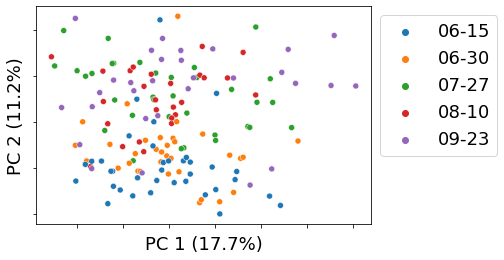

In [143]:
# without filtering
ax = sns.scatterplot(x = 'PCA1_bc', y = 'PCA2_bc', hue = 'Sample date', data = plotting_df,
                    hue_order = ['06-15', '06-30','07-27','08-10','09-23'])
# for i, txt in enumerate(plotting_df['Sample']):
#     ax.text(plotting_df['PCA1_bc'][i], plotting_df['PCA2_bc'][i], txt)
ax.legend(scatterpoints=1, bbox_to_anchor=(1, 1), loc='upper left', fontsize = 18)
ax.set_xlabel('PC %d (%.1f%%)' % (1, full_pc.proportion_explained[0]*100), size=18)
ax.set_ylabel('PC %d (%.1f%%)' % (2, full_pc.proportion_explained[1]*100), size=18)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.gca().invert_yaxis()
# ax.legend(labels=['ARD MiSeq V34', 'Pen MiSeq V34', 'ARD MinION V34', 'Pen MinION V34', 'ARD MinION Full', 'Pen MinION Full'])
# plt.savefig('../Figures/ordination_all_otus_unfiltered.jpg', bbox_inches = 'tight', dpi = 300)

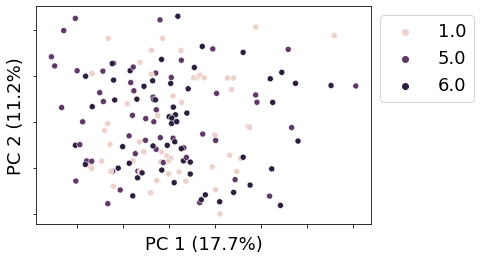

In [144]:
# with filtering
ax = sns.scatterplot(x = 'PCA1_bc', y = 'PCA2_bc', hue = 'Nitrogen', data = plotting_df)
# for i, txt in enumerate(plotting_df['Sample']):
#     ax.text(plotting_df['PCA1_bc'][i], plotting_df['PCA2_bc'][i], txt)
ax.legend(scatterpoints=1, bbox_to_anchor=(1, 1), loc='upper left', fontsize = 18)
ax.set_xlabel('PC %d (%.1f%%)' % (1, full_pc.proportion_explained[0]*100), size=18)
ax.set_ylabel('PC %d (%.1f%%)' % (2, full_pc.proportion_explained[1]*100), size=18)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.gca().invert_yaxis()
# ax.legend(labels=['ARD MiSeq V34', 'Pen MiSeq V34', 'ARD MinION V34', 'Pen MinION V34', 'ARD MinION Full', 'Pen MinION Full'])
# plt.savefig('../Figures/ordination_all_otus_unfiltered.jpg', bbox_inches = 'tight', dpi = 300)

# Alpha diversity

In [146]:
taxa_df = data.loc[:, 'barcode01a':].fillna(0)
taxa_df['Phyla'] = data['phylum']
taxa_df.set_index('Phyla', inplace = True)
taxa_df = taxa_df.T
taxa_df = taxa_df[~taxa_df.index.isin(barcode_controls)]*100
taxa_df.head()

Phyla,Verrucomicrobia,Verrucomicrobia,Verrucomicrobia,Verrucomicrobia,Verrucomicrobia,Acidobacteria,Acidobacteria,Actinobacteria,Bacteroidetes,Acidobacteria,...,Actinobacteria,Proteobacteria,Proteobacteria,Proteobacteria,Firmicutes,Firmicutes,Firmicutes,Firmicutes,Firmicutes,Proteobacteria
barcode01a,1.009086,2.185236,0.499323,0.647124,0.512686,0.761336,10.292602,0.609067,0.669522,4.517167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
barcode02a,0.889774,1.556734,0.478033,0.132950,0.189443,2.413692,8.433513,1.308634,0.297127,1.684270,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
barcode03a,0.712808,1.474273,0.480199,0.000000,0.000000,1.057296,5.121126,1.267909,1.147681,1.340643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
barcode04a,0.574317,1.113694,0.326357,0.282718,0.191616,0.598940,14.220451,1.318769,0.383560,3.511598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
barcode05a,0.761783,1.349353,0.782786,0.000000,0.000000,4.319095,5.825977,1.399531,0.690111,1.287591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
taxa_df.loc['barcode02a'].sum()

99.99999999999896

In [148]:
mapping_file

,Sample date,Sample ID,Plot,ID,Nitrogen,Water,Block,Direction,Barcode,Notes,Barcode_key
Sample name,,,,,,,,,,,
2,07-27,15N,15N,225.0,5.0,2.0,2.0,N,1.0,NxW_A library,barcode01a
6,07-27,32N,32N,311.0,1.0,1.0,3.0,N,2.0,NxW_A library,barcode02a
15,07-27,8N,8N,121.0,1.0,2.0,1.0,N,3.0,NxW_A library,barcode03a
16,07-27,2S,2S,111.0,1.0,1.0,1.0,S,4.0,NxW_A library,barcode04a
19,07-27,30N,30N,321.0,1.0,2.0,3.0,N,5.0,NxW_A library,barcode05a
...,...,...,...,...,...,...,...,...,...,...,...
218,06-15,14S,14S,221.0,1.0,2.0,2.0,S,78.0,NxW_B library,barcode78b
219,06-15,26N,26N,326.0,6.0,2.0,3.0,N,79.0,NxW_B library,barcode79b
220,06-15,32S,32S,311.0,1.0,1.0,3.0,S,80.0,NxW_B library,barcode80b


In [149]:
tmp_key = mapping_file[['Barcode_key','Nitrogen','Water']].set_index('Barcode_key')
taxa_df_merged = pd.merge(taxa_df, tmp_key, left_index=True, right_index=True)

In [150]:
taxa_df_merged_nitrogen = taxa_df_merged.groupby('Nitrogen').mean()
taxa_df_merged_nitrogen = taxa_df_merged_nitrogen.drop('Water', axis = 1)
taxa_df_merged_nitrogen = taxa_df_merged_nitrogen.T.reset_index().groupby('index').sum().T
for i in taxa_df_merged_nitrogen:
    if taxa_df_merged_nitrogen[i].sum() < 5:
#         print('yes', i)
        taxa_df_merged_nitrogen = taxa_df_merged_nitrogen.rename(columns = {i:'Other'})
taxa_df_merged_nitrogen = taxa_df_merged_nitrogen.groupby(taxa_df_merged_nitrogen.columns, axis=1).sum()

Text(0.5, 0, 'Nitrogen treatment')

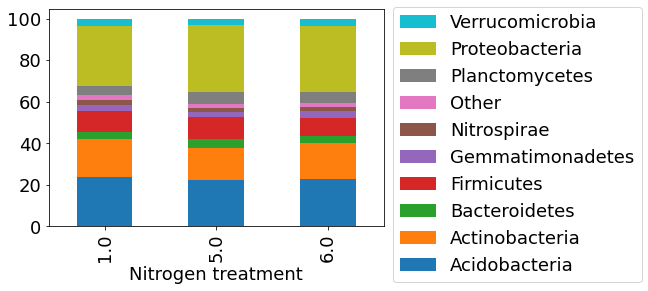

In [151]:
ax = taxa_df_merged_nitrogen.plot(kind='bar', stacked=True, cmap='tab10', fontsize=18)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.0, 1.05), loc=2, fontsize = 18)
ax.set_xlabel('Nitrogen treatment', fontsize = 18)

In [152]:
taxa_df_merged_water = taxa_df_merged.groupby('Water').mean()
taxa_df_merged_water = taxa_df_merged_water.drop('Nitrogen', axis = 1)
taxa_df_merged_water = taxa_df_merged_water.T.reset_index().groupby('index').sum().T
for i in taxa_df_merged_water:
    if taxa_df_merged_water[i].sum() < 5:
#         print('yes', i)
        taxa_df_merged_water = taxa_df_merged_water.rename(columns = {i:'Other'})
taxa_df_merged_water = taxa_df_merged_water.groupby(taxa_df_merged_water.columns, axis=1).sum()

Text(0.5, 0, 'Water treatment')

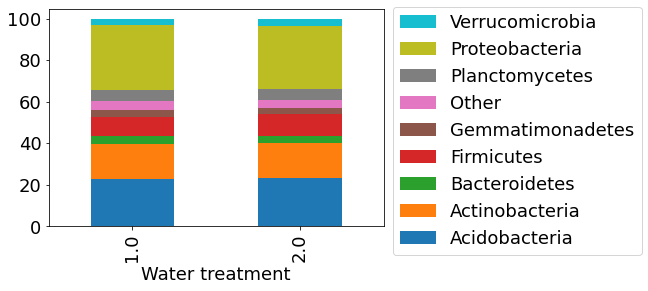

In [153]:
ax = taxa_df_merged_water.plot(kind='bar', stacked=True, cmap='tab10', fontsize=18)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.0, 1.05), loc=2, fontsize = 18)
ax.set_xlabel('Water treatment', fontsize = 18)

In [154]:
observed_otus = alpha_diversity('observed_otus', otu_table, otu_table.index)
shannon = alpha_diversity('shannon', otu_table, otu_table.index)

In [155]:
alpha_diversity_df = pd.merge(mapping_file.set_index('Barcode_key'), pd.DataFrame(observed_otus, columns = ['Observed species']), left_index=True, right_index=True)
alpha_diversity_df = pd.merge(alpha_diversity_df, pd.DataFrame(shannon, columns = ['Shannon']), left_index=True, right_index=True)

[Text(0, 0, '100'), Text(1, 0, '70')]

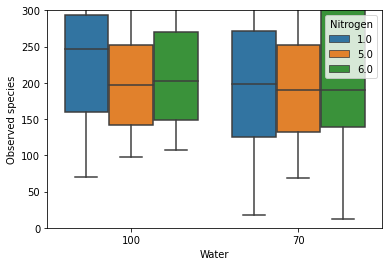

In [156]:
ax = sns.boxplot(y = 'Observed species', x = 'Water', hue = 'Nitrogen', data = alpha_diversity_df)
plt.ylim([0,300])
ax.set_xticklabels(['100','70'])

# Differential abundance

In [157]:
otu_table_simple = otu_table.loc[(otu_table.sum(axis=1) != 0), (otu_table.sum(axis=0) != 0)]
otu_table_simple_psuedo = otu_table_simple.replace(0, 0.001)
print(otu_table_simple_psuedo.shape)
otu_table_simple_psuedo.head()

(160, 1321)


tax_id,1324935,191863,690879,2736,748857,658062,1612172,496014,1892851,1855912,...,2021234,354197,1929097,1341696,1867775,193462,171685,386490,1605891,1581680
barcode01a,0.010091,0.021852,0.004993,0.006471,0.005127,0.007613,0.102926,0.006091,0.006695,0.045172,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
barcode02a,0.008898,0.015567,0.004780,0.001330,0.001894,0.024137,0.084335,0.013086,0.002971,0.016843,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
barcode03a,0.007128,0.014743,0.004802,0.001000,0.001000,0.010573,0.051211,0.012679,0.011477,0.013406,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
barcode04a,0.005743,0.011137,0.003264,0.002827,0.001916,0.005989,0.142205,0.013188,0.003836,0.035116,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
barcode05a,0.007618,0.013494,0.007828,0.001000,0.001000,0.043191,0.058260,0.013995,0.006901,0.012876,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001


In [158]:
mapping_file.head()

,Sample date,Sample ID,Plot,ID,Nitrogen,Water,Block,Direction,Barcode,Notes,Barcode_key
Sample name,,,,,,,,,,,
2,07-27,15N,15N,225.0,5.0,2.0,2.0,N,1.0,NxW_A library,barcode01a
6,07-27,32N,32N,311.0,1.0,1.0,3.0,N,2.0,NxW_A library,barcode02a
15,07-27,8N,8N,121.0,1.0,2.0,1.0,N,3.0,NxW_A library,barcode03a
16,07-27,2S,2S,111.0,1.0,1.0,1.0,S,4.0,NxW_A library,barcode04a
19,07-27,30N,30N,321.0,1.0,2.0,3.0,N,5.0,NxW_A library,barcode05a


In [ ]:
results_df_full = pd.DataFrame()

In [176]:
grouping_df = mapping_file[mapping_file['Barcode_key'].isin(otu_table_simple.index)]
grouping_df = grouping_df.reset_index().set_index('Barcode_key')
grouping = grouping_df['Sample date'].astype('str')
print(len(grouping))

160


In [ ]:
#Currently for Nitrogen

In [177]:
ancom_df, percentile_df = ancom(otu_table_simple_psuedo, grouping)
ancom_df['W']

/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:3641: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


tax_id
1324935    1103
191863        7
690879     1205
2736          6
748857        6
           ... 
193462       17
171685       18
386490       19
1605891      19
1581680      19
Name: W, Length: 1321, dtype: int64

In [178]:
results_df = ancom_df[ancom_df['Reject null hypothesis'] == True].copy()
results_df['Grouping'] = 'Sample date'

In [179]:
results_df_full = pd.concat([results_df_full, results_df])
results_df_full

,W,Reject null hypothesis,Grouping
tax_id,,,
121290,1186,True,Nitrogen
666686,1111,True,Nitrogen
42256,1279,True,Water
49319,1215,True,Water
690879,1205,True,Sample date
1892851,1192,True,Sample date
2024524,1167,True,Sample date
1210884,1234,True,Sample date
1737571,1219,True,Sample date


In [180]:
results_df.to_csv('../Results/ancom_treatments_dates.csv')

In [93]:
data[data['tax_id'] == 666686]

,superkingdom,phylum,class,order,family,genus,species,tax_id,barcode01,barcode02,...,barcode86,barcode87,barcode88,barcode89,barcode90,barcode91,barcode92,barcode93,barcode95,barcode96
188,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,Bacillus sp. 1NLA3E,666686,NaN,0.003842,...,0.004764,NaN,0.001989,0.002401,0.005044,0.004039,NaN,NaN,0.003576,NaN


In [101]:
percentile_df[50.0].loc[666686]

Group
1.0    0.003637
5.0    0.001000
6.0    0.001000
Name: 666686, dtype: float64

In [102]:
#Water
grouping = grouping_df['Water'].astype('str')
print(len(grouping))
ancom_df, percentile_df = ancom(otu_table_simple_psuedo, grouping)
ancom_df['W']

81


/home/bostevens/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:3641: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


tax_id
1324935    0
191863     0
690879     0
2736       0
748857     0
          ..
403962     0
1604721    0
2202148    0
29543      0
1393       0
Name: W, Length: 767, dtype: int64

In [103]:
ancom_df[ancom_df['Reject null hypothesis'] == True]

,W,Reject null hypothesis
tax_id,,


# RDA

In [106]:
# taxa_list = 
# otu_table_simple.head()